### MGMTMFE405-2 Computational Methods in Finance
#### Project 5: Least Square Monte Carlo Simulation
#### February 22, 2019
#### Hyeuk Jung (005259560)

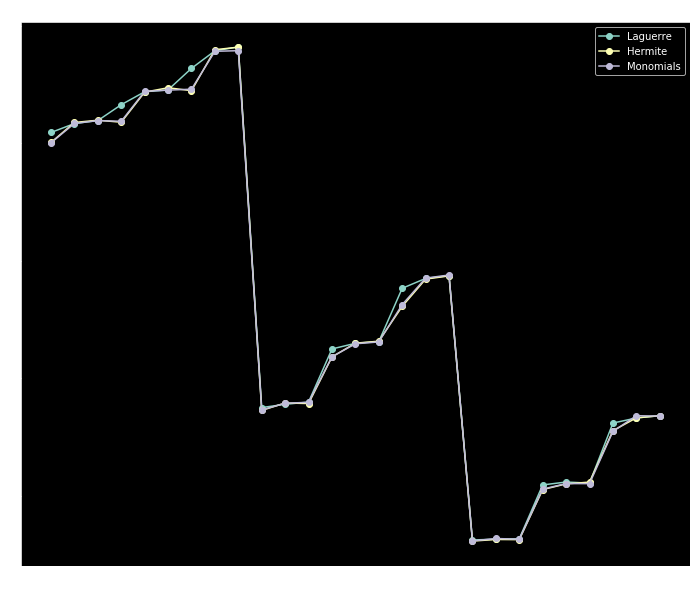

Q1 LSMC Method Results:
      S    T  K  Laguerre_put  Hermite_put  Monomials_put
0   36  0.5  2      4.091728     4.006703       4.003883
1   36  0.5  3      4.167622     4.177074       4.168673
2   36  0.5  4      4.193153     4.196000       4.192879
3   36  1.0  2      4.328252     4.179077       4.187160
4   36  1.0  3      4.438506     4.435113       4.441752
5   36  1.0  4      4.454404     4.472581       4.452170
6   36  2.0  2      4.637903     4.447671       4.460474
7   36  2.0  3      4.786940     4.796658       4.783112
8   36  2.0  4      4.820422     4.818088       4.788118
9   40  0.5  2      1.749016     1.724582       1.729171
10  40  0.5  3      1.776771     1.787928       1.785985
11  40  0.5  4      1.795939     1.783275       1.793684
12  40  1.0  2      2.248102     2.180360       2.181480
13  40  1.0  3      2.296272     2.297379       2.292113
14  40  1.0  4      2.310563     2.314300       2.307908
15  40  2.0  2      2.764762     2.611046       2.625944
16  40

In [3]:
#
# Jung_Hyeuk_Project5.py
# MGMTMFE405-2 Computational Methods in Finance - Project 5
# Hyeuk Jung (005259560)
#

import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(int(time.time()))

start = time.time()

# 1. LSMC method
def laguerre(x, k):
    term_1 = np.exp(-1*x/2) 
    term_2 = np.exp(-1*x/2)*(1 - x) 
    term_3 = np.exp(-1*x/2)*(1 - 2*x + (x**2)/2) 
    term_4 = np.exp(-1*x/2)*(1 - 3*x + 3*(x**2)/2 - (x**3)/6) 
    terms = np.column_stack([term_1, term_2, term_3, term_4]) # combined by column
    return(terms[:, :k])

def hermite(x, k):
    term_1 = np.ones(len(x))
    term_2 = 2*x
    term_3 = 4*x*x - 2
    term_4 = 8*(x**3) - 12*x
    terms = np.column_stack([term_1, term_2, term_3, term_4])
    return(terms[:, :k])

def monomials(x, k):
    term_1 = np.ones(len(x))
    term_2 = x
    term_3 = x*x
    term_4 = x*x*x
    terms = np.column_stack([term_1, term_2, term_3, term_4])
    return(terms[:, :k])

def stockPrice(S0, T, r, sd, n, step):
    # Stock prices: Generate 50,000 paths and 50,000 antithetic variates paths
    dt = T/step
    stocks = np.zeros((2*n, step+1))
    stocks[:, 0] = S0
    z = np.random.normal(0, 1, n*step).reshape(n, step)
    w = np.sqrt(dt)*z
    w_anti = np.sqrt(dt)*(-1)*z
    W = np.concatenate((w, w_anti), axis=0)
    
    for i in range(1, step+1, 1):
        stocks[:, i] = stocks[:, i-1]*np.exp((r-sd*sd/2)*dt + sd*W[:, i-1])
    
    return stocks

def lsmc(S0, T, K, r, sd, n, step, func, k): # n: number of paths
    dt = T/step
    stocks = stockPrice(S0, T, r, sd, n, step)/K # scaling values by the exercise value to improve the accuracy

    # American put
    # initialize option value, continuation value, and index matrix
    option = np.zeros((2*n, step+1))
    index = np.zeros((2*n, step+1))
    cv = np.zeros((2*n, step+1))

    # fill in the payoff at time T & and set index = 1 if payoff > 0, indicating the exercise period
    option[:, step] = np.maximum(K/K - stocks[:, step], 0) 
    index[:, step] = np.where(option[:, step] > 0, 1, 0)

    # discount matrix: discount factors for each time period * repeat for the number of paths
    discount = np.tile(np.exp(-r*dt* np.arange(0, step + 1, 1)), (2*n, 1)) 

    for i in range(step-1, 0, -1):
        # exercise value at time t: ev > 0 row indexes
        exercise = np.where(K/K - stocks[:, i] > 0)[0]
        #exercise x paths' index at time t --> for getting discounted cv
        exercisex = list(set(range(2*n)) - set(exercise))
            
        # if exercisable nodes do not exist -> use entire stock prices at time t for regression
        if len(exercisex) == 2*n:
            exercise = np.where(stocks[:, i])[0]
            exercisex = list(set(range(2*n)) - set(exercise))

        # X = stocks[exercise, i] 
        F = func(stocks[exercise, i], k) 
        # real continued value: discount next step(time t+1)'s option prices
        y = np.exp(-1*r*dt)*option[exercise, i+1] 
        
        # LSCM continuation value at t
        A = np.dot(np.transpose(F), F) 
        b = np.dot(np.transpose(F), y) 
        coef = np.dot(np.linalg.pinv(A), b) 

        # fill in the continuation value using either the model or the discounted values
        cv[exercise, i] = np.dot(F, coef)
        cv[exercisex, i] = np.exp(-1*r*dt)*cv[exercisex, i+1]

        # update index (early exercise time period) and option matrix
        index[:, i] = np.where(np.maximum(K/K - stocks[:, i], 0) > cv[:, i], 1, 0) 
        option[:, i] = np.maximum(np.maximum(K/K - stocks[:, i], 0), cv[:, i])
        
    # np.argmax(index, axis=1): column-wise -> exercise moment for each path
    final = np.zeros((2*n, step+1))
    final[np.arange(0, 2*n, 1), np.argmax(index, axis=1)] = 1 # early exercise points
    return np.sum(final*discount*option*K)/(2*n) 


# 1. (a) Laguerre
S0 = 40; sd = 0.2; rf = 0.06; n = 50000; step = 100
X = 40; T = [0.5, 1, 2]; k = [2, 3, 4]; S = [36, 40, 44]
result_laguerre = dict()
for s in S:
    for t in T:
        for kk in k:
            result_laguerre[(s, t, kk)] = lsmc(s, t, X, rf, sd, n, step, laguerre, kk)

df_laguerre = pd.concat([pd.DataFrame(list(result_laguerre.keys())), pd.DataFrame(list(result_laguerre.values()))], axis=1)
df_laguerre.columns = ['S', 'T', 'K', 'Laguerre_put']

# 1. (b) Hermite
result_hermite = dict()
for s in S:
    for t in T:
        for kk in k:
            result_hermite[(s, t, kk)] = lsmc(s, t, X, rf, sd, n, step, hermite, kk)

df_hermite = pd.concat([pd.DataFrame(list(result_hermite.keys())), pd.DataFrame(list(result_hermite.values()))], axis=1)
df_hermite.columns = ['S', 'T', 'K', 'Hermite_put']

# 1. (c) Simple Monomials
result_monomials = dict()
for s in S:
    for t in T:
        for kk in k:
            result_monomials[(s, t, kk)] = lsmc(s, t, X, rf, sd, n, step, monomials, kk)

df_monomials = pd.concat([pd.DataFrame(list(result_monomials.keys())), pd.DataFrame(list(result_monomials.values()))], axis=1)
df_monomials.columns = ['S', 'T', 'K', 'Monomials_put']

# Q1 consolidation (plots and results)
plt.figure(figsize=(12,10))
plt.plot(df_laguerre['Laguerre_put'], label = 'Laguerre', marker='o')
plt.plot(df_hermite['Hermite_put'], label = 'Hermite', marker='o')
plt.plot(df_monomials['Monomials_put'], label = 'Monomials', marker='o')
plt.legend()
plt.title('Put option values')
plt.show()

combinded = pd.concat([df_laguerre, df_hermite['Hermite_put'], df_monomials['Monomials_put']], axis=1)
print('Q1 LSMC Method Results:\n', combinded)



(The x-axis is the combination of stock price S, time to maturity T, and the level of terms for polynomials K.
Please refer to the table above for the detail.)

In theory, the result of all three polynomials should converge to real values. Hermite and Simple Monomials
polynomials hold quite accurate results, supporting the theory. Also the accuracy improves as the K increases
for the both cases. However, the result of Laguerre polynomials is quite different. The deviation would be due to
the stock price paths which affect all of polynomial terms.

In [4]:
# 2. Forward-start options
def forwardStart(type, S0, T, r, sd, npath, step, t, func, k): # npath: # of paths
    dt = T/step
    stocks = stockPrice(S0, T, r, sd, npath, step)
    K = stocks[:, int((1/dt)*t)] 
    # exercise price St ex. dt = 1/100 -> 1/dt = 100 -> (1/dt)*t = 20 => t at 0.2

    #discount matrix for American forward start option
    discount = np.tile(np.exp(-r*dt* np.arange(0, step + 1, 1)), (2*npath, 1))

    option = np.zeros((2*npath, step+1))
    if type == "E":
        # European forward
        # find the fwd value at time T and discount it to time 0
        option[:, step] = np.maximum(K - stocks[:, step], 0) 
        fwd_value = np.exp(-1*r*T)*np.sum(option)/(2*npath)


    elif type == "A":
        # American forward
        # initialize option value, continuation value, and index matrix
        index = np.zeros((2*npath, step+1))
        cv = np.zeros((2*npath, step+1))

        # fill in the payoff at time T & and set index = 1 if payoff > 0, indicating the exercise period
        option[:, step] = np.maximum(K - stocks[:, step], 0) 
        index[:, step] = np.where(option[:, step] > 0, 1, 0)

        for i in range(step-1, int((1/dt)*t), -1): # from t = 1 to t = 0.2 
            # exercise value at time t: ev > 0 row indexes
            exercise = np.where(K - stocks[:, i] > 0)[0]
            #exercise x paths' index at time t --> for getting discounted cv
            exercisex = list(set(range(2*npath)) - set(exercise)) 

            # if exercisable nodes do not exist -> use entire stock prices at time t for regression
            if len(exercisex) == 2*npath:
                exercise = np.where(stocks[:, i])[0]
                exercisex = list(set(range(2*npath)) - set(exercise))

            # X = stocks[exercise, i] 
            F = func(stocks[exercise, i], k) 
            # real continued value
            y = np.exp(-1*r*dt)*option[exercise, i+1] 
        
            # LSCM continuation value at t
            A = np.dot(np.transpose(F), F) 
            b = np.dot(np.transpose(F), y) 
            coef = np.dot(np.linalg.pinv(A), b) 

            # fill in the continuation value using either the model or the discounted values
            cv[exercise, i] = np.dot(F, coef)
            cv[exercisex, i] = np.exp(-1*r*dt)*cv[exercisex, i+1]

            index[:, i] = np.where(np.maximum(K - stocks[:, i], 0) > cv[:, i], 1, 0) 
            option[:, i] = np.maximum(np.maximum(K - stocks[:, i], 0), cv[:, i])
        
        # np.argmax(index, axis=1): column-wise -> exercise moment for each path
        final = np.zeros((2*npath, step+1))
        final[np.arange(0, 2*npath, 1), np.argmax(index, axis=1)] = 1 # early exercise points
        fwd_value = np.sum(final*discount*option)/(2*npath)
    
    else:
        print('ERROR: Choose option type.') 
    
    return fwd_value 


S0 = 65; K = 60; sd = 0.20; r = 0.06; t = 0.2; T = 1 # t: exercise start time
npath = 50000; step = 100

# 2. (a) European put
fwd_european_put = forwardStart("E", S0, T, r, sd, npath, step, t, monomials, 3)
print('2 (a). Forward-Start European Put:', fwd_european_put)

# 2. (b) American put
fwd_american_put = forwardStart("A", S0, T, r, sd, npath, step, t, monomials, 3)
print('2 (b). Forward-Start American Put:', fwd_american_put)

total_execution = time.time() - start
print('Total execution time:', total_execution)


2 (a). Forward-Start European Put: 3.1586810297623265
2 (b). Forward-Start American Put: 3.241488512884028
Total execution time: 443.07620191574097
